In [1]:
import sys
import os
import json
import matplotlib.pyplot as plt
import numpy as np

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TextStreamer
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config

parent_path = os.path.dirname(os.getcwd())
target_dir = f'{parent_path}/model_to_graph'
sys.path.append(target_dir)

# import Relay_compiler
import graph_visualization as gv
import hardware as hw
import dijkstra as dijk
import stacked_graph as sg
import testing as test
import data_collection as dc
from main import forward


/home/rjtomich/miniconda3/envs/schedule/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Regular Inference (gpt2)

In [2]:
def generate_token(model_name, prompt):
    # model = AutoModelForCausalLM.from_pretrained(model_name, torchscript=True)
    # tokenizer = AutoTokenizer.from_pretrained(model_name)

    model = GPT2LMHeadModel.from_pretrained("gpt2")
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

    tokenizer.pad_token = tokenizer.eos_token
    streamer = TextStreamer(tokenizer)

    model.tie_weights()

    inputs = tokenizer(prompt, return_tensors="pt", padding=True)
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]



    model = model.eval()  # Change to eval mode

    # gen_tokens = model.generate(input_ids, do_sample=False, max_new_tokens=10, streamer=streamer)
    gen_tokens = model.generate(
                                    input_ids,
                                    attention_mask=attention_mask,
                                    do_sample=False,
                                    max_length=15,
                                    pad_token_id=tokenizer.pad_token_id,
                                    streamer=streamer
                                )

    gen_text = tokenizer.decode(gen_tokens[0], skip_special_tokens=True)

    return input_ids, gen_tokens, gen_text
    return int(gen_tokens[0][-1])

model_name = 'gpt2'
prompt = "my favorite music is"

prompt_tokens, gen_tokens, gen_text = generate_token(model_name, prompt)
print(f'{"Prompt Tokens:":<20} {prompt_tokens}')
print(f'{"Generated Tokens:":<20} {gen_tokens}')

my favorite music is "The Last of Us" by the Grateful Dead.
Prompt Tokens:       tensor([[1820, 4004, 2647,  318]])
Generated Tokens:    tensor([[ 1820,  4004,  2647,   318,   366,   464,  4586,   286,  4021,     1,
           416,   262, 44249,  5542,    13]])


# Export the model to TVM Relay IR

Precomputed to save time (takes about 1 minuet for gpt2)

In [3]:
# model_onnx, input_ids = transformer_torch_to_onnx(model_name, prompt, save=False)
# lib = onnx_to_relay(model_onnx, input_ids, write=True, model_name=model_name, opt_level=0)

# Visualize computational Graph
Computational graph visualization for one token generation

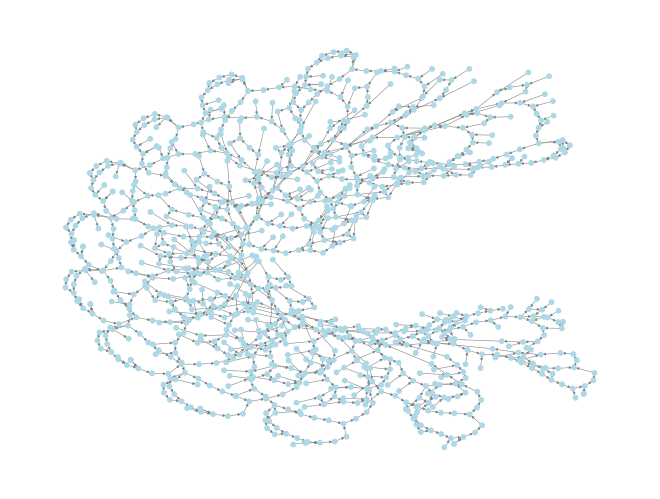

In [4]:
relay_path = "gpt2_graph.json"

CPU_MAX_CLOCK = 5.0875 * 10**9
CPU_AVERAGE_CLOCK = 3.208 * 10**9
PHU_MIN_CLOCK = 10 * 10**9 #100**9, 10 Ghz

hardware = []
hw.Hardware._hardware_reset()
# hardware.append(hw.CPU(CPU_MAX_CLOCK, 1))
hardware.append(hw.CPU(CPU_AVERAGE_CLOCK, 1))
# hardware.append(hw.PHU(PHU_MIN_CLOCK, 1, 20))

available_hardware = hw.initilize_hardware(hardware)

optimization = 'time'
# optimization = 'energy'

with open(relay_path, encoding="utf-8") as json_file:
    raw_json = json.load(json_file)  # returns json file as dict

WEIGHT_VARIABLE = optimization
graph = sg.StackGraph(raw_json=raw_json, weight_variable=WEIGHT_VARIABLE)
gv.adj_to_graph(graph, ax=1, layout='kk', title=f'Subgraph', stack=True)


# Optimizations
1) Subdevide
2) Stack
3) select

# Create Simulation Enviroment

In [5]:
relay_path = "gpt2_graph.json"

CPU_MAX_CLOCK = 5.0875 * 10**9
CPU_AVERAGE_CLOCK = 3.208 * 10**9
PHU_MIN_CLOCK = 10 * 10**9 #100**9, 10 Ghz

hardware = []
hw.Hardware._hardware_reset()
hardware.append(hw.CPU(CPU_MAX_CLOCK, 1))
# hardware.append(hw.CPU(CPU_AVERAGE_CLOCK, 1))
# hardware.append(hw.PHU(PHU_MIN_CLOCK, 1, 20))

available_hardware = hw.initilize_hardware(hardware)

optimization = 'time'
# optimization = 'energy'

 3 / 28


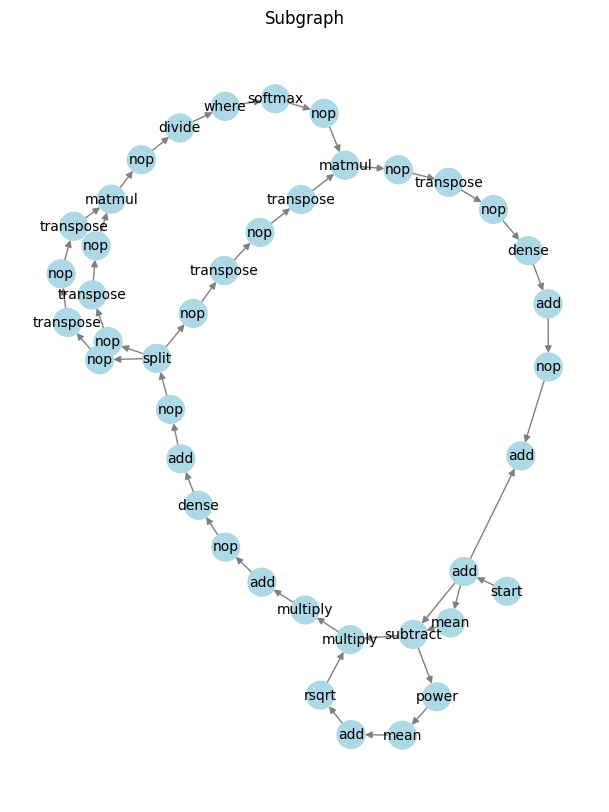

In [6]:
def draw_subgraphs(subgraph, sub = False):
    fig, ax = plt.subplots(figsize=(10, 10))

    gv.adj_to_graph(subgraph, ax=ax, layout='kk', title=f'Subgraph')
    # plt.tight_layout()
    plt.show()

subgraph_to_plot = 3

with open(relay_path, encoding="utf-8") as json_file:
    raw_json = json.load(json_file)  # returns json file as dict

WEIGHT_VARIABLE = optimization
graph = sg.StackGraph(raw_json=raw_json, weight_variable=WEIGHT_VARIABLE)
stacked_subgraphs = list(dijk.graph_partition(graph))
flat_subgraphs = dijk.select_nodes(
    stacked_subgraphs, weight_variable=WEIGHT_VARIABLE, config=None
)
expanded_flat_subgraphs = dijk.expand_nodes(flat_subgraphs)

print(f' 3 / {len(flat_subgraphs)}')


draw_subgraphs(flat_subgraphs[subgraph_to_plot])


# MAC's in GP2 Inference

In [7]:
scheduled_flat_graph, end_time, break_points = dijk.schdeule_nodes(
    graph, expanded_flat_subgraphs, available_hardware
)
print(end_time)
time_profile = dc.get_time_profile(scheduled_flat_graph)
energy_profile = dc.get_energy_per_opp(scheduled_flat_graph)
print(time_profile)
print(energy_profile)

0.04041
{'where': 2.555282555282555e-09, 'add': 0.00015339400491400483, 'less': 1.9656019656019657e-10, 'nop': 4.0687960687960835e-08, 'mean': 3.0230958230958245e-05, 'transpose': 5.072196560196567e-05, 'split': 2e-09, 'divide': 4.52874692874693e-07, 'multiply': 0.0001461275675675676, 'softmax': 2.717248157248158e-06, 'dense': 0.03982162800589681, 'subtract': 1.509582309582309e-05, 'matmul': 2.3766863882063875e-05, 'rsqrt': 1.9656019656019646e-08, 'take': 1.9656019656019657e-10, 'power': 4.4079803439803446e-05, 'tanh': 0.00011593592137592141, 'get_dram': 0.0}
{'where': 1.2999999999999999e-11, 'add': 1.4799999999999977e-10, 'less': 1e-12, 'nop': 2.0699999999999957e-10, 'mean': 5.000000000000006e-11, 'transpose': 8.4e-11, 'split': 1.1999999999999999e-11, 'divide': 1.1999999999999999e-11, 'multiply': 9.799999999999995e-11, 'softmax': 1.1999999999999999e-11, 'dense': 4.9412812800000015e-05, 'subtract': 2.4999999999999998e-11, 'matmul': 2.9491199999999997e-08, 'rsqrt': 2.4999999999999998e-1

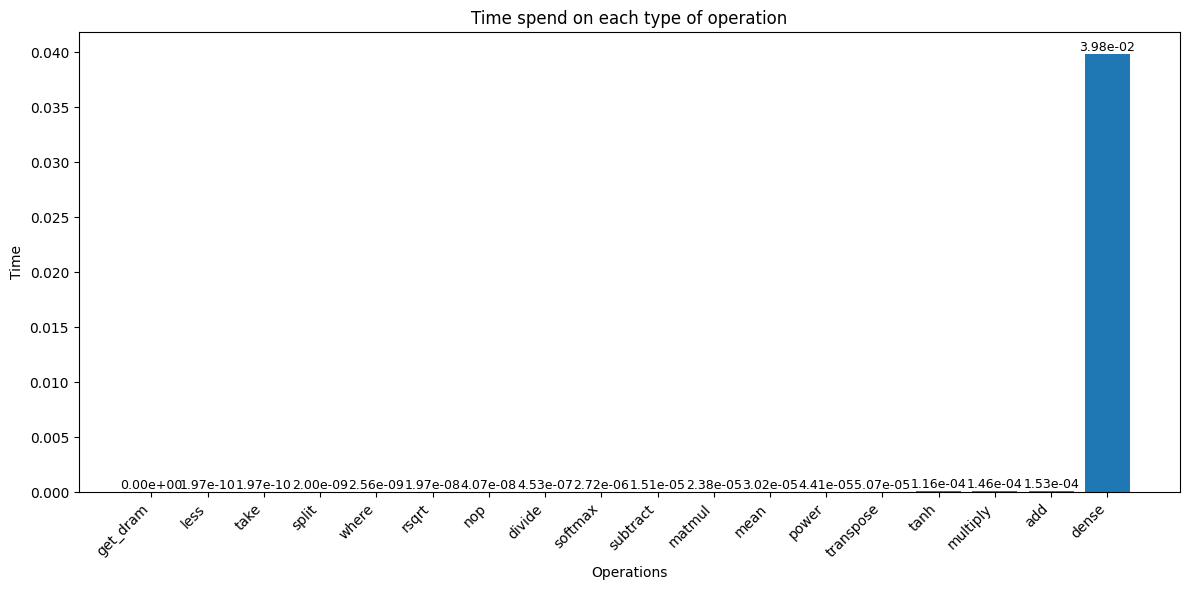

In [8]:
time_profile_sorted = dict(sorted(time_profile.items(), key=lambda item: item[1]))
energy_profile_sorted = dict(sorted(energy_profile.items(), key=lambda item: item[1]))


labels = list(time_profile_sorted.keys())
values = list(time_profile_sorted.values())

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(labels, values)

ax.set_xlabel('Operations')
ax.set_ylabel('Time')
ax.set_title('Time spend on each type of operation')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2e}', va='bottom', ha='center', fontsize=9)

# Show plot
plt.tight_layout()
plt.show()


# End to End

In [10]:
relay_path = "gpt2_graph.json"

CPU_MAX_CLOCK = 5.0875 * 10**9
CPU_AVERAGE_CLOCK = 3.208 * 10**9
PHU_MIN_CLOCK = 10 * 10**9 #100**9, 10 Ghz

hardware = []
hw.Hardware._hardware_reset()
hardware.append(hw.CPU(CPU_MAX_CLOCK, 1))
# hardware.append(hw.CPU(CPU_AVERAGE_CLOCK, 1))
# hardware.append(hw.PHU(PHU_MIN_CLOCK, 1, 20))

available_hardware = hw.initilize_hardware(hardware)

optimization = 'time'
# optimization = 'energy'

forward(relay_path, optimization, available_hardware, profiles = False, get_step_times=False)

0.04041
---------- INFO ----------
WEIGHT_VARIABLE='time'
Photonic Selected: 0 / 0
{'start', 'get_dram'}
Makespan: 0.04041 s
Number of Nodes: 1108
---------- ---- ----------
